# Prediction Metrics

Run on test set to get prediction metrics.

In [36]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy

In [45]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll
import matplotlib.pyplot as plt

In [3]:
# local
sys.path.append("/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/")
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [4]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    model_control = keras.models.load_model("/users/surag/oak/projects/SMC_ZEB_KD_TomQ/bpnet/models/202100507_gc_neg_filt256_in2346_out2000/control/2021-05-07_01_54_44/7DETFO.h5")
    model_kd = keras.models.load_model("/users/surag/oak/projects/SMC_ZEB_KD_TomQ/bpnet/models/202100507_gc_neg_filt256_in2346_out2000/kd/2021-05-07_01_49_14/RugCJF.h5")

In [6]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [5]:
MODEL_INP_LEN = model_control.input_shape[0][1]
print(MODEL_INP_LEN)

2346


In [10]:
control_peaks =  pd.read_csv("~/oak/projects/SMC_ZEB_KD_TomQ/bpnet/peaks/control.overlap.merged.bed",
                           sep='\t',
                           names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "7"])
print(control_peaks.shape)
control_peaks.head()

(99523, 10)


,chr,start,end,1,2,3,4,5,6,7
0,chr1,628674,631020,.,.,.,.,.,.,1173
1,chr1,629889,632235,.,.,.,.,.,.,1173
2,chr1,630912,633258,.,.,.,.,.,.,1173
3,chr1,632858,635204,.,.,.,.,.,.,1173
4,chr1,777584,779930,.,.,.,.,.,.,1173


In [11]:
control_gc_neg_peaks =  pd.read_csv("/users/surag/oak/projects/SMC_ZEB_KD_TomQ/bpnet/peaks/control.gc.neg.bed",
                           sep='\t',
                           names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "7"])
print(control_gc_neg_peaks.shape)
control_gc_neg_peaks.head()

(99523, 10)


,chr,start,end,1,2,3,4,5,6,7
0,chr1,16314084,16316430,.,.,.,.,.,.,1173
1,chr1,89783766,89786112,.,.,.,.,.,.,1173
2,chr1,21360330,21362676,.,.,.,.,.,.,1173
3,chr1,231571314,231573660,.,.,.,.,.,.,1173
4,chr1,44649072,44651418,.,.,.,.,.,.,1173


In [15]:
set(control_gc_neg_peaks['end']-control_gc_neg_peaks['start'])

{2346}

In [16]:
set(control_peaks['end']-control_peaks['start'])

{2346}

In [74]:
control_peaks.shape

(99523, 10)

In [13]:
control_bw = pyBigWig.open("/users/surag/oak/projects/SMC_ZEB_KD_TomQ/bigwigs/control.bw")

## Predict

In [23]:
def pred_on_peaks(model, peaks_df, batch_size=1024):
    pred_cts = []
    pred_prof = []
    
    for i in tqdm.tqdm(range(math.ceil(len(peaks_df)/batch_size))):
        cur_seqs = peaks_df[i*batch_size:(i+1)*batch_size]
        cur_raw_seqs = []
        for j, r in cur_seqs.iterrows():        
            cur_raw_seqs.append(str(hg38[r['chr']][r['start']:r['end']]))

        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)

        cur_pred = model.predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])
        
        pred_prof.append(cur_pred[0])
        pred_cts.append(cur_pred[1])

    pred_cts = np.vstack(pred_cts).ravel()
    pred_prof = np.vstack(pred_prof)
    
    return pred_prof, pred_cts

In [29]:
def get_cts(bw, peaks_df):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(np.nan_to_num(bw.values(r['chr'], r['start'], r['end'])))
        
    return np.array(vals)

In [28]:
peaks_to_pred = control_peaks[control_peaks['chr']=="chr1"]
control_peaks_pred_prof, control_peaks_pred_cts = pred_on_peaks(model_control, peaks_to_pred)

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


In [33]:
control_peak_cts = get_cts(control_bw, peaks_to_pred)

In [40]:
import scipy.stats

In [89]:
print(scipy.stats.pearsonr(np.log(control_peak_cts.sum(-1)+1),
                     (control_peaks_pred_cts)-1)[0])

print(scipy.stats.spearmanr(np.log(control_peak_cts.sum(-1)+1),
                     (control_peaks_pred_cts)-1)[0])

0.6900189369977108
0.6401022858277325


In [46]:
from scipy.stats import gaussian_kde

In [98]:
"{:.4f}".format(0.123213)

'0.1232'

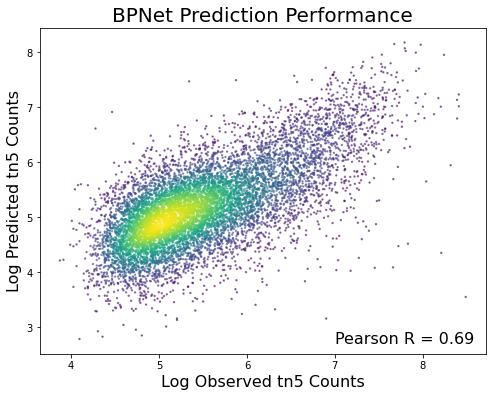

In [103]:
plt.rcParams["figure.figsize"] = (8,6)

x = np.log(1+control_peak_cts.sum(-1))
y = control_peaks_pred_cts
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
# plt.plot([min(random_pred_counts_control), max(random_pred_counts_control)], [0,0], '-k', label='y=2x+1')
plt.annotate("Pearson R = {:.2f}".format(scipy.stats.pearsonr(x,y)[0]), (7,2.7), fontsize=16)
plt.title("BPNet Prediction Performance", fontsize=20)
plt.xlabel("Log Observed tn5 Counts", fontsize=16)
plt.ylabel("Log Predicted tn5 Counts", fontsize=16)
plt.savefig("peaks_perf.pdf")

In [56]:
gc_neg_peaks_to_pred = control_gc_neg_peaks[control_gc_neg_peaks['chr']=="chr1"]
control_gc_neg_peaks_pred_prof, control_gc_neg_peaks_pred_cts = pred_on_peaks(model_control, gc_neg_peaks_to_pred)

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


In [57]:
control_gc_neg_peak_cts = get_cts(control_bw, gc_neg_peaks_to_pred)

In [58]:
# check gc neg has lower actual and predicted counts

In [62]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

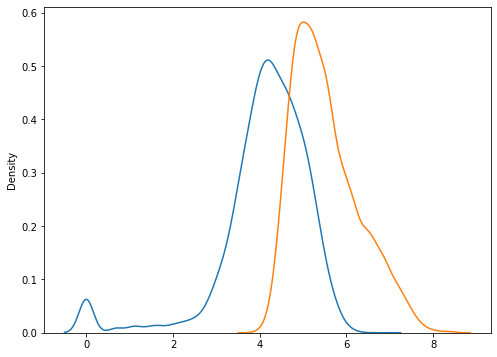

In [64]:
sns.kdeplot(np.log(1+control_gc_neg_peak_cts.sum(-1)))
sns.kdeplot(np.log(1+control_peak_cts.sum(-1)))

<AxesSubplot:ylabel='Density'>

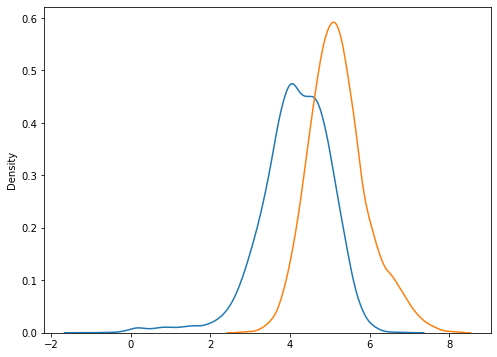

In [72]:
sns.kdeplot(control_gc_neg_peaks_pred_cts)
sns.kdeplot(control_peaks_pred_cts)

In [73]:
np.median(control_peaks_pred_cts), np.median(control_gc_neg_peaks_pred_cts)

(5.142309, 4.199413)

In [78]:
control_all_cts = np.log(np.array(list(control_peak_cts.sum(-1))+ list(control_gc_neg_peak_cts.sum(-1)))+1)
control_all_pred_cts = list(control_peaks_pred_cts) + list(control_gc_neg_peaks_pred_cts)

print(scipy.stats.pearsonr(control_all_cts, control_all_pred_cts)[0])
print(scipy.stats.spearmanr(control_all_cts, control_all_pred_cts)[0])

0.7956499552481717
0.8043437162333138


Text(0, 0.5, 'Predicted tn5 Counts')

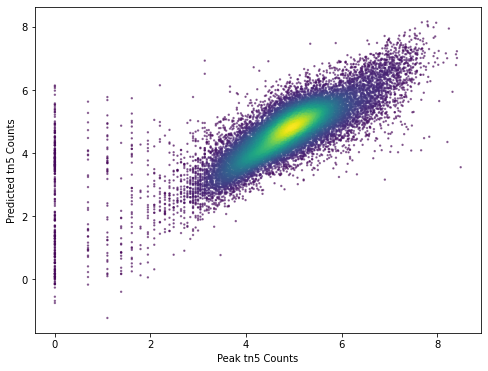

In [86]:
plt.rcParams["figure.figsize"] = (8,6)

x = control_all_cts
y = control_all_pred_cts
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
# plt.plot([min(random_pred_counts_control), max(random_pred_counts_control)], [0,0], '-k', label='y=2x+1')
plt.xlabel("Peak tn5 Counts")
plt.ylabel("Predicted tn5 Counts")
# plt.savefig("image.jpg", dpi=300)